# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [ ]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA

# Partie 1 : Architecture VGG16

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg
!wget --content-disposition https://unsplash.com/photos/EerxztHCjM8/download?force=true -O koala.jpg
!wget --content-disposition https://unsplash.com/photos/favQn8WgRyk/download?force=true -O deer.jpg

--2025-12-31 10:52:45--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl [following]
--2025-12-31 10:52:46--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl.2’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0.001s  

2025-12-31 10:52:46 (24.0 MB/s) - ‘imagenet_classes.pkl.2’ saved [3

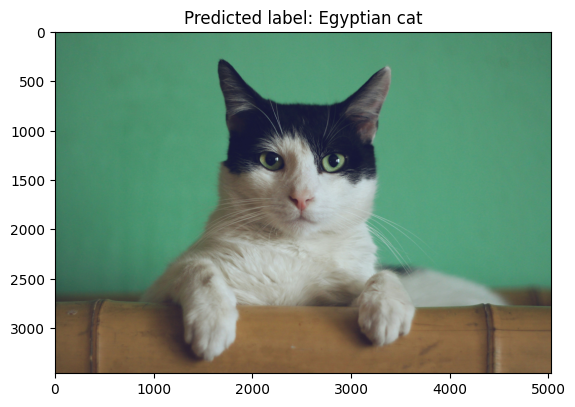

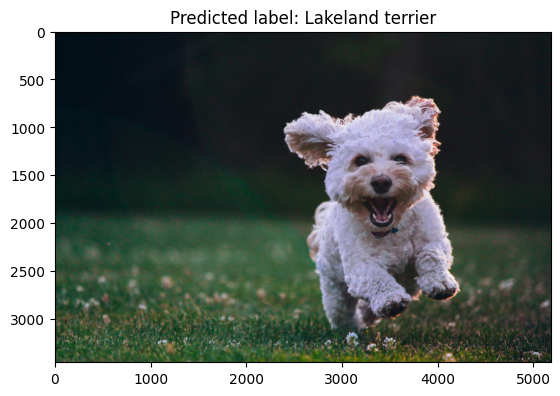

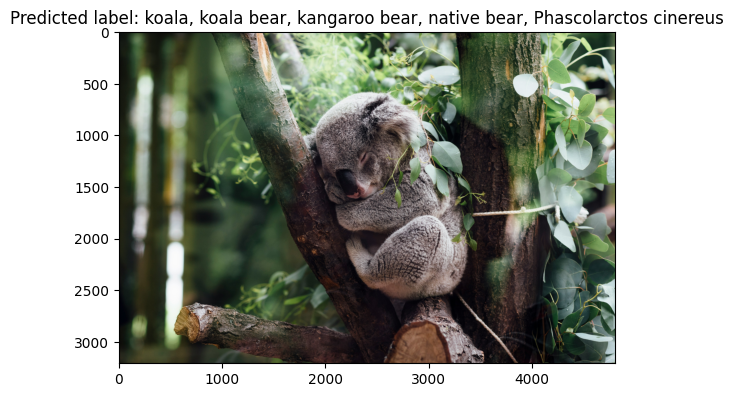

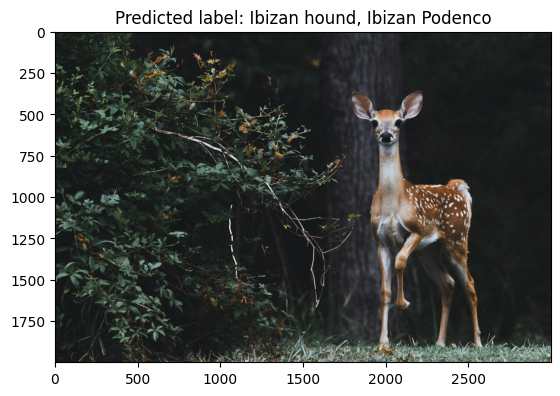

In [ ]:
# Loading ImageNet classes
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))

# Loding pre-trained VGG
vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
vgg16.eval() # WHY THAT ?

for nameim in ['cat', 'dog', 'koala', 'deer']:
    nameim = nameim + ".jpg"
    img = original_img = Image.open(nameim)

    # Normalization
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img, dtype=np.float32) / 255
    img = img.transpose((2, 0, 1))
    # ImageNet mean/std
    img_tensor = torch.Tensor(img)
    mu = torch.Tensor([0.485, 0.456, 0.406])
    sigma = torch.Tensor([0.229, 0.224, 0.225])
    # Expand mu & sigma to match image size
    mu = mu.expand(224, 224, 3).reshape_as(img_tensor)
    sigma = sigma.expand(224, 224, 3).reshape_as(img_tensor)

    # compute the normalized image with mean ImageNet image
    img = (img_tensor - mu) / sigma

    # Forward pass on VGG
    img = np.expand_dims(img, 0)
    x = torch.Tensor(img)
    y = vgg16(x).detach()
    y = y.numpy() # transformation en array numpy

    # Get prediction (i.e., ImageNet class label)
    idx = y.argmax()
    label = imagenet_classes[idx]

    plt.title(f'Predicted label: {label}')
    plt.imshow(original_img)
    plt.show()

**Bonus** : Visualize several activation maps obtained after the first convolutional layer. How can we
interpret them?

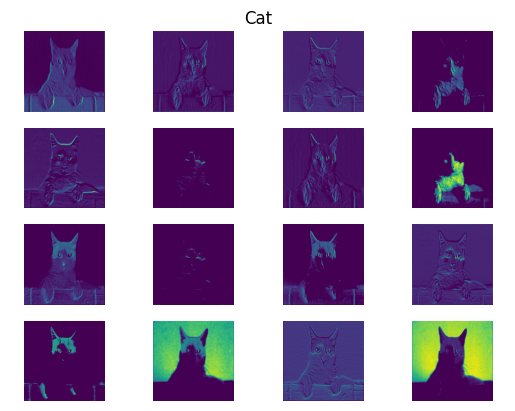

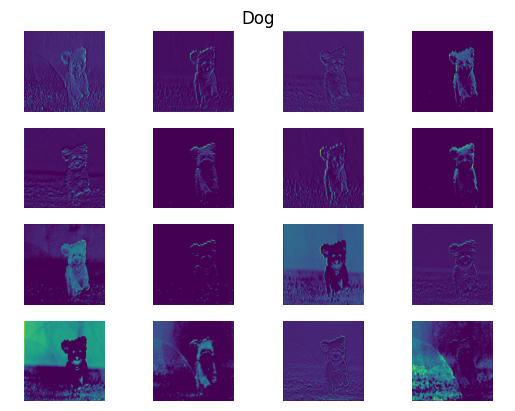

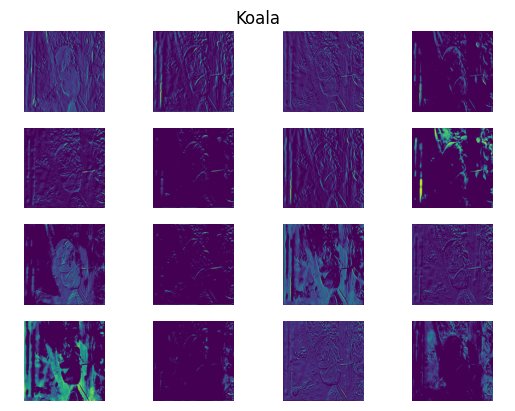

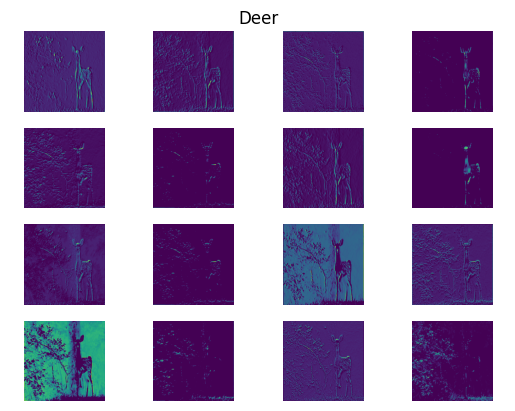

In [ ]:
first_conv = vgg16.features[:2]

for name in ['cat', 'dog', 'koala', 'deer']:
    nameim = name + ".jpg"
    img = original_img = Image.open(nameim)

    # Normalization
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img, dtype=np.float32) / 255
    img = img.transpose((2, 0, 1))
    # ImageNet mean/std
    img_tensor = torch.Tensor(img)
    mu = torch.Tensor([0.485, 0.456, 0.406])
    sigma = torch.Tensor([0.229, 0.224, 0.225])
    # Expand mu & sigma to match image size
    mu = mu.expand(224, 224, 3).reshape_as(img_tensor)
    sigma = sigma.expand(224, 224, 3).reshape_as(img_tensor)

    # compute the normalized image with mean ImageNet image
    img = (img_tensor - mu) / sigma

    # Forward pass on VGG
    img = np.expand_dims(img, 0)
    x = torch.Tensor(img)
    y = first_conv(x).detach()
    y = y.numpy()[0] # transformation en array numpy

    plt.title(name.capitalize())
    plt.axis('off')
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.axis('off')
        plt.imshow(y[i,:,:])
    plt.show()

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

--2025-12-31 10:53:12--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip [following]
--2025-12-31 10:53:12--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip.2’

15ScenesData.zip.2  100%[===================>]  82.51M   399MB/s    in 0.2s    

2025-12-31 10:53:15 (399 MB/s) - ‘15ScenesData.zip.2’ saved [86520868/86520

In [ ]:
!ls 15SceneData/test/bedroom/

image_0003.jpg	image_0042.jpg	image_0082.jpg	image_0124.jpg	image_0170.jpg
image_0004.jpg	image_0043.jpg	image_0084.jpg	image_0128.jpg	image_0175.jpg
image_0006.jpg	image_0047.jpg	image_0086.jpg	image_0130.jpg	image_0176.jpg
image_0007.jpg	image_0049.jpg	image_0087.jpg	image_0131.jpg	image_0180.jpg
image_0008.jpg	image_0050.jpg	image_0088.jpg	image_0134.jpg	image_0182.jpg
image_0011.jpg	image_0052.jpg	image_0090.jpg	image_0135.jpg	image_0189.jpg
image_0013.jpg	image_0053.jpg	image_0092.jpg	image_0138.jpg	image_0190.jpg
image_0014.jpg	image_0054.jpg	image_0093.jpg	image_0140.jpg	image_0191.jpg
image_0016.jpg	image_0056.jpg	image_0095.jpg	image_0141.jpg	image_0192.jpg
image_0017.jpg	image_0059.jpg	image_0096.jpg	image_0142.jpg	image_0195.jpg
image_0018.jpg	image_0060.jpg	image_0097.jpg	image_0144.jpg	image_0196.jpg
image_0019.jpg	image_0062.jpg	image_0098.jpg	image_0148.jpg	image_0200.jpg
image_0020.jpg	image_0063.jpg	image_0103.jpg	image_0150.jpg	image_0202.jpg
image_0021.jpg	image_0064

In [ ]:
class VGG16relu7(nn.Module):
  def __init__(self):
    super(VGG16relu7, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(vgg16.features.children()))
    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])
    self.n_output_features = 4096
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [ ]:
PRINT_INTERVAL = 50
CUDA = True

mu = [0.485, 0.456, 0.406]
sigma = [0.229, 0.224, 0.225]

def get_dataset(batch_size, path):

    # This function expands 3 times a gray level image
    # to transform it into an image RGB. Use it with transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img)
        return img
    def resizeImage(img):
      return img.resize((224,224), Image.BILINEAR)

    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Add pre-processing
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([
            transforms.Lambda(duplicateChannel),
            transforms.Lambda(resizeImage),
            transforms.ToTensor(),
            transforms.Normalize(mu, sigma)
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([
            transforms.Lambda(duplicateChannel),
            transforms.Lambda(resizeImage),
            transforms.ToTensor(),
            transforms.Normalize(mu, sigma)
        ]))
    ####################
    ##      END        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [ ]:
def extract_features(data, model, batch_size=8):
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # init features matrices
    features = model(torch.zeros(1, 3, 224, 224).cuda()).shape[1]
    print(f'Features size: {features}')
    X = torch.zeros(len(data.dataset), features)
    y = torch.zeros(len(data.dataset))
    ####################
    ##      END        #
    ####################

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        #####################
        ## YOUR CODE HERE  ##
        #####################
        with torch.no_grad():
            start_idx = i * batch_size
            end_idx = start_idx + input.size(0)
            X[start_idx:end_idx, :] = model(input).cpu()
            y[start_idx:end_idx] = target
        ####################
        ##      END        #
        ####################

    return X, y


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

    print('Instanciation de VGG16relu7')
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = VGG16relu7()
    ####################
    ##      END        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    accuracy = svm.score(X_test, y_test)
    ####################
    ##      FIN        #
    ####################
    print('Accuracy = %f' % accuracy)


In [ ]:
main("15SceneData", 8)

Instanciation de VGG16
Instanciation de VGG16relu7
Récupération des données
Feature extraction
Features size: 4096
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Features size: 4096
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 0.885762


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Change the layer at which the features are extracted. What is the importance of the depth of this
layer? What is the representation size and what does this change?

In [ ]:
class VGG16features(nn.Module):

  def __init__(self, n_feature_layers=len(list(vgg16.features.children()))):
    super(VGG16features, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(vgg16.features.children())[:n_feature_layers])

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    return x

In [ ]:
def main_bonus(path="15SceneData", batch_size=8, model=VGG16features(), Cs=[1.0], dim_red=False):

    model.eval()
    if CUDA:
        cudnn.benchmark = True
        model = model.cuda()

    train, test = get_dataset(batch_size, path)

    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    if dim_red:
        print('Dim reduction')
        pca = PCA(n_components=100)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)

    print('SVM train:')
    for C in Cs:
        svm = LinearSVC(C=C)
        svm.fit(X_train, y_train)
        accuracy = svm.score(X_test, y_test)

        print(f'Accuracy = {accuracy:.5f}, C={C}')

In [ ]:
main_bonus(model=VGG16features(n_feature_layers=-1))

Features size: 100352
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Features size: 100352
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM train:
Accuracy = 0.88744, C=1.0


In [ ]:
main_bonus(model=VGG16features(n_feature_layers=-4))

Features size: 100352
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Features size: 100352
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM train:
Accuracy = 0.88174, C=1.0


Try other available pre-trained networks. What are the differences between these networks?

In [ ]:
class ResNetFineTuning(nn.Module):

  def __init__(self):
    super(ResNetFineTuning, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential(*list(models.resnet18(weights=models.ResNet18_Weights.DEFAULT).children())[:-1])

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    return x

In [ ]:
main_bonus(model=ResNetFineTuning())

Features size: 512
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Features size: 512
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM train:
Accuracy = 0.88007, C=1.0


In [ ]:
class AlexNetFineTuning(nn.Module):

  def __init__(self):
    super(AlexNetFineTuning, self).__init__()
    self.features = nn.Sequential(*list(models.alexnet(weights=models.AlexNet_Weights.DEFAULT).children())[:-1])

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    return x

In [ ]:
main_bonus(model=AlexNetFineTuning())

Features size: 9216
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Features size: 9216
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM train:
Accuracy = 0.85662, C=1.0


Tune the parameter C to improve performance.

In [ ]:
main_bonus(model=VGG16relu7(), Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0])

Features size: 4096
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Features size: 4096
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM train:
Accuracy = 0.88911, C=0.001
Accuracy = 0.88576, C=0.01
Accuracy = 0.88610, C=0.1


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy = 0.88576, C=1.0
Accuracy = 0.88576, C=10.0
Accuracy = 0.88576, C=100.0


Instead of training an SVM, replace the last layer of VGG16 with a new fully-connected layer and
continue to train the network on 15 Scene (with or without propogating the gradients to the rest of
the network).

In [ ]:
def main_fc_layer(path="15SceneData", batch_size=8, model=VGG16relu7(), back_prop=True):

    train, test = get_dataset(batch_size, path)

    print('FC layer train:')
    features = model(torch.zeros(1, 3, 224, 224).cuda()).shape[1]
    clf = nn.Linear(features, 15)
    loss = nn.CrossEntropyLoss()
    if back_prop:
        optimizer = torch.optim.SGD([
            {'params': model.parameters(), 'lr': 1e-4},
            {'params': clf.parameters(), 'lr': 0.01}
        ], momentum=0.9)
    else:
        optimizer = torch.optim.SGD(clf.parameters(), lr=0.01, momentum=0.9)
        model.eval()
        for param in model.parameters():
            param.requires_grad = False

    if CUDA:
        cudnn.benchmark = True
        model = model.cuda()
        clf = clf.cuda()
        loss = loss.cuda()

    for epoch in range(20):
        print(f'Epoch {epoch + 1}')
        for i, (input, target) in enumerate(train):
            if i % PRINT_INTERVAL == 0:
                print('Batch {0:03d}/{1:03d}'.format(i, len(train)))
            if CUDA:
                input = input.cuda()
                target = target.cuda()
            output = clf(model(input))
            loss_value = loss(output, target)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

    model.eval()
    accuracy = 0.0
    for i, (input, target) in enumerate(test):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(test)))
        if CUDA:
            input = input.cuda()
            target = target.cuda()
        output = clf(model(input))
        accuracy += (output.argmax(dim=1) == target).float().sum()

    accuracy /= len(test.dataset)

    print('Accuracy = %f' % accuracy)

In [ ]:
# Full back-prop
main_fc_layer()

FC layer train:
Epoch 1
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 2
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 3
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 4
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 5
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 6
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 7
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 8
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 9
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 10
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 11
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 12
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 13
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 14
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 15
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 16
Batch 000

In [ ]:
# Only clf back-prop
main_fc_layer(back_prop=False)

FC layer train:
Epoch 1
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 2
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 3
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 4
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 5
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 6
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 7
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 8
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 9
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 10
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 11
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 12
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 13
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 14
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 15
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Epoch 16
Batch 000

Look into methods for dimensionality reduction before classification and their impact on performance and execution time.

In [ ]:
main_bonus(model=VGG16relu7(), dim_red=True)

Features size: 4096
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Features size: 4096
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Dim reduction
SVM train:
Accuracy = 0.81340, C=1.0
